In [69]:
!pip3 install scipy streamlit plotly xgboost fastparquet pyarrow nbformat

Defaulting to user installation because normal site-packages is not writeable


In [70]:
import nbformat
print(nbformat.__version__)

5.10.4


# 1. Importing Libraries

In [71]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import kurtosis, skew, median_abs_deviation
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [72]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_selection import SelectKBest, f_regression
import io
from scipy import stats
from itertools import combinations
from xgboost import XGBRegressor



# 2. Data Loading and Preprocessing

In [73]:
def load_data():
    try:
        df = pd.read_parquet('calorie_expenditure.parquet', engine='fastparquet')
        return df
    except OSError:
        # Try with pyarrow engine if fastparquet fails
        df = pd.read_parquet('calorie_expenditure.parquet', engine='pyarrow')


In [74]:
df = load_data()
df.pop('id')
df.head()

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4  female   38   166.0    61.0      25.0       102.0       40.6     146.0

# 3. Exploratary Data Analysis

Data Distribution

In [75]:
display(df['Sex'].value_counts())

Sex
female    375721
male      374279
Name: count, dtype: int64

Data Description

In [76]:
display(df.describe())

Age         Height         Weight       Duration  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       41.420404     174.697685      75.145668      15.421015   
std        15.175049      12.824496      13.982704       8.354095   
min        20.000000     126.000000      36.000000       1.000000   
25%        28.000000     164.000000      63.000000       8.000000   
50%        40.000000     174.000000      74.000000      15.000000   
75%        52.000000     185.000000      87.000000      23.000000   
max        79.000000     222.000000     132.000000      30.000000   

          Heart_Rate      Body_Temp       Calories  
count  750000.000000  750000.000000  750000.000000  
mean       95.483995      40.036253      88.282781  
std         9.449845       0.779875      62.395349  
min        67.000000      37.100000       1.000000  
25%        88.000000      39.600000      34.000000  
50%        95.000000      40.300000      77.000000  
75%       103.000000      40.700000     136.000000  
max       128.000000      41.500000     314.000000

Missing or NULL values

In [77]:
display(df.isnull().sum())

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Distribution Plots analysing Continous Variables

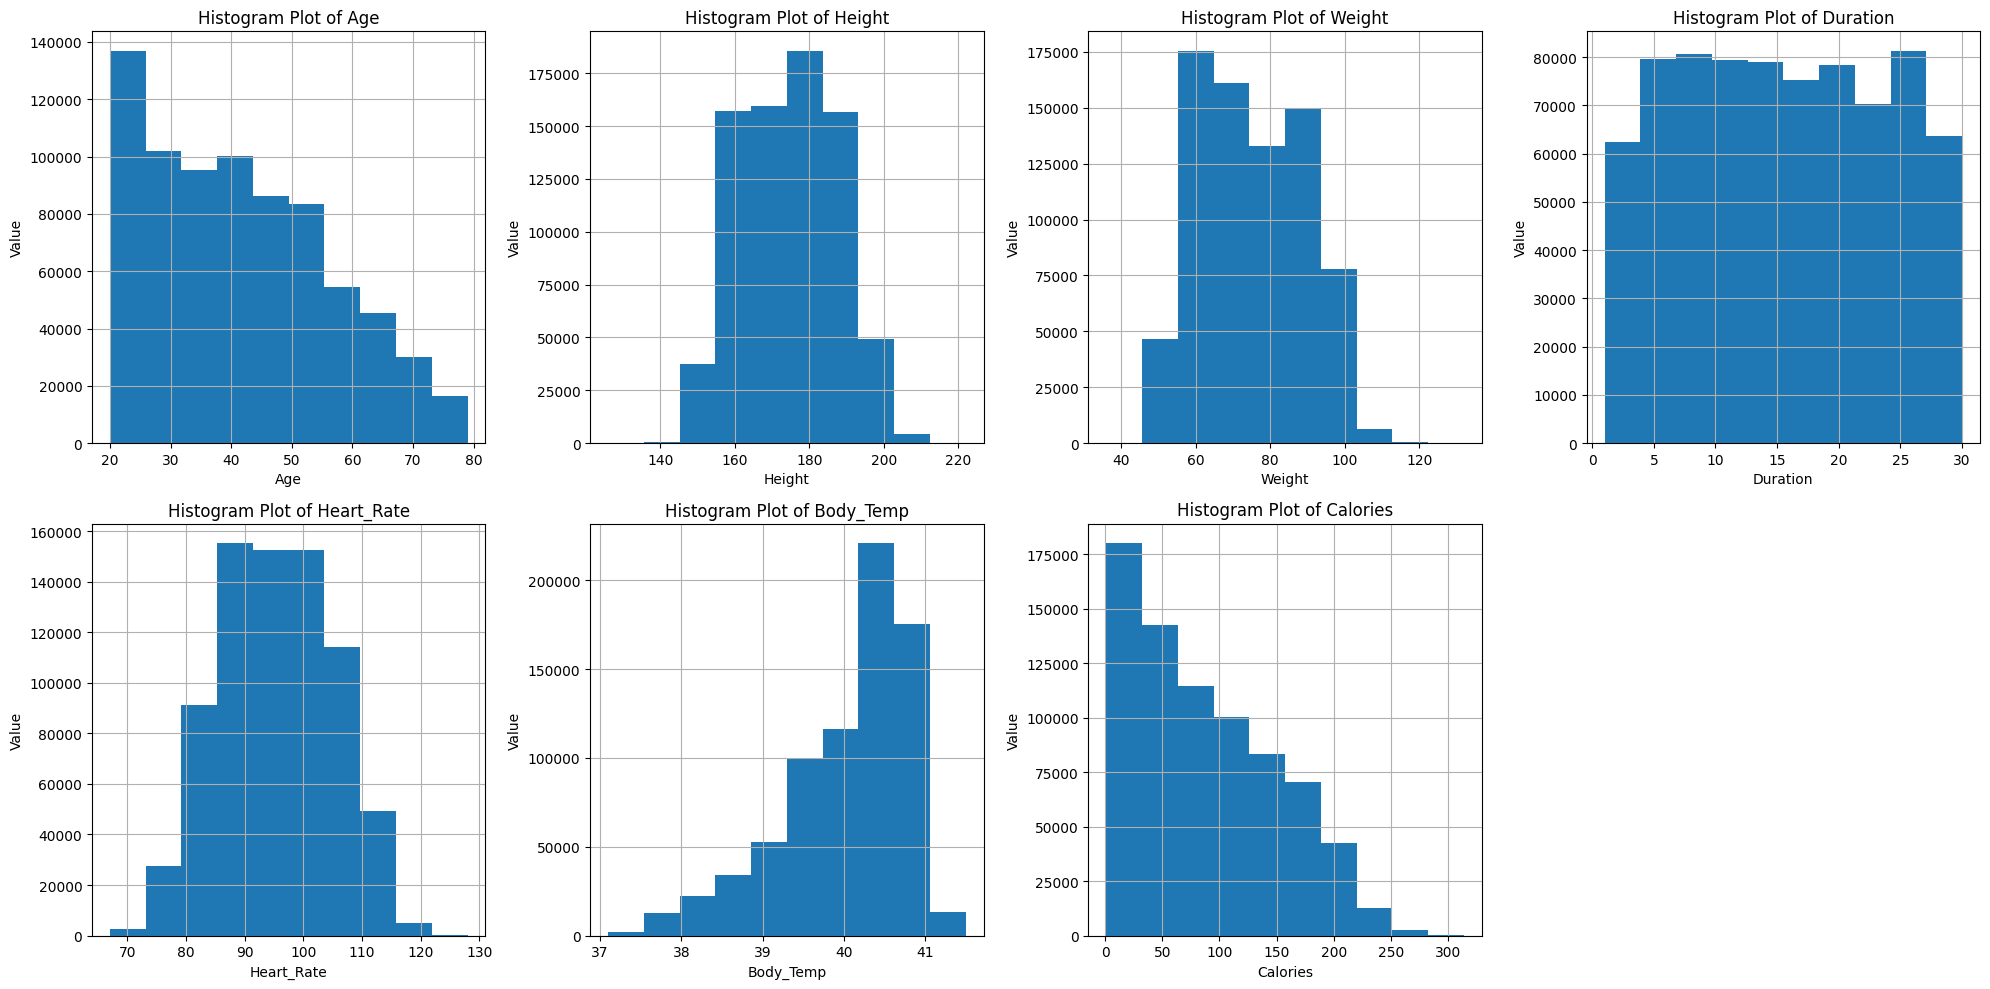

In [78]:
features = ['Age','Height','Weight','Duration','Heart_Rate','Body_Temp','Calories']
fig,axes = plt.subplots(nrows=2, ncols = 4,figsize = (20,10))
axes = axes.flatten()

for i,feature in enumerate(features):
    axes[i].hist(df[feature])
    axes[i].set_title(f'Histogram Plot of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Value')
    axes[i].grid(True)

for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Skewness

In [79]:
for x in features:
    print(f"Feature: {x}, Skewness: {skew(df[x]):.3f}")

Feature: Age, Skewness: 0.436
Feature: Height, Skewness: 0.052
Feature: Weight, Skewness: 0.211
Feature: Duration, Skewness: 0.026
Feature: Heart_Rate, Skewness: -0.006
Feature: Body_Temp, Skewness: -1.022
Feature: Calories, Skewness: 0.539


**Observation:**
1. Age and Calories - Right skewed data
2. Height, Weight and Heart Rate - Normal Data
3. Body_Temp - Left Skewed Data
4. Duration - Uniform Data

In [80]:
print('Kurtosis:')
for x in features:
    print(f"Feature: {x}, Kurtosis: {kurtosis(df[x],fisher=True):.3f}")


Kurtosis:
Feature: Age, Kurtosis: -0.746
Feature: Height, Kurtosis: -0.840
Feature: Weight, Kurtosis: -0.996
Feature: Duration, Kurtosis: -1.195
Feature: Heart_Rate, Kurtosis: -0.677
Feature: Body_Temp, Kurtosis: 0.520
Feature: Calories, Kurtosis: -0.690


**Observation:**
Type	Kurtosis Value (excess kurtosis)	Description
Mesokurtic	≈ 0	Normal distribution shape
Leptokurtic	> 0	Heavy tails and sharp peak (more outliers)
Platykurtic	< 0	Light tails and flat peak (fewer outliers)

So, in our data **Body Temperature** has kurtossi greater than 0, indicating high outliers.

Analysing Outliers using box plots

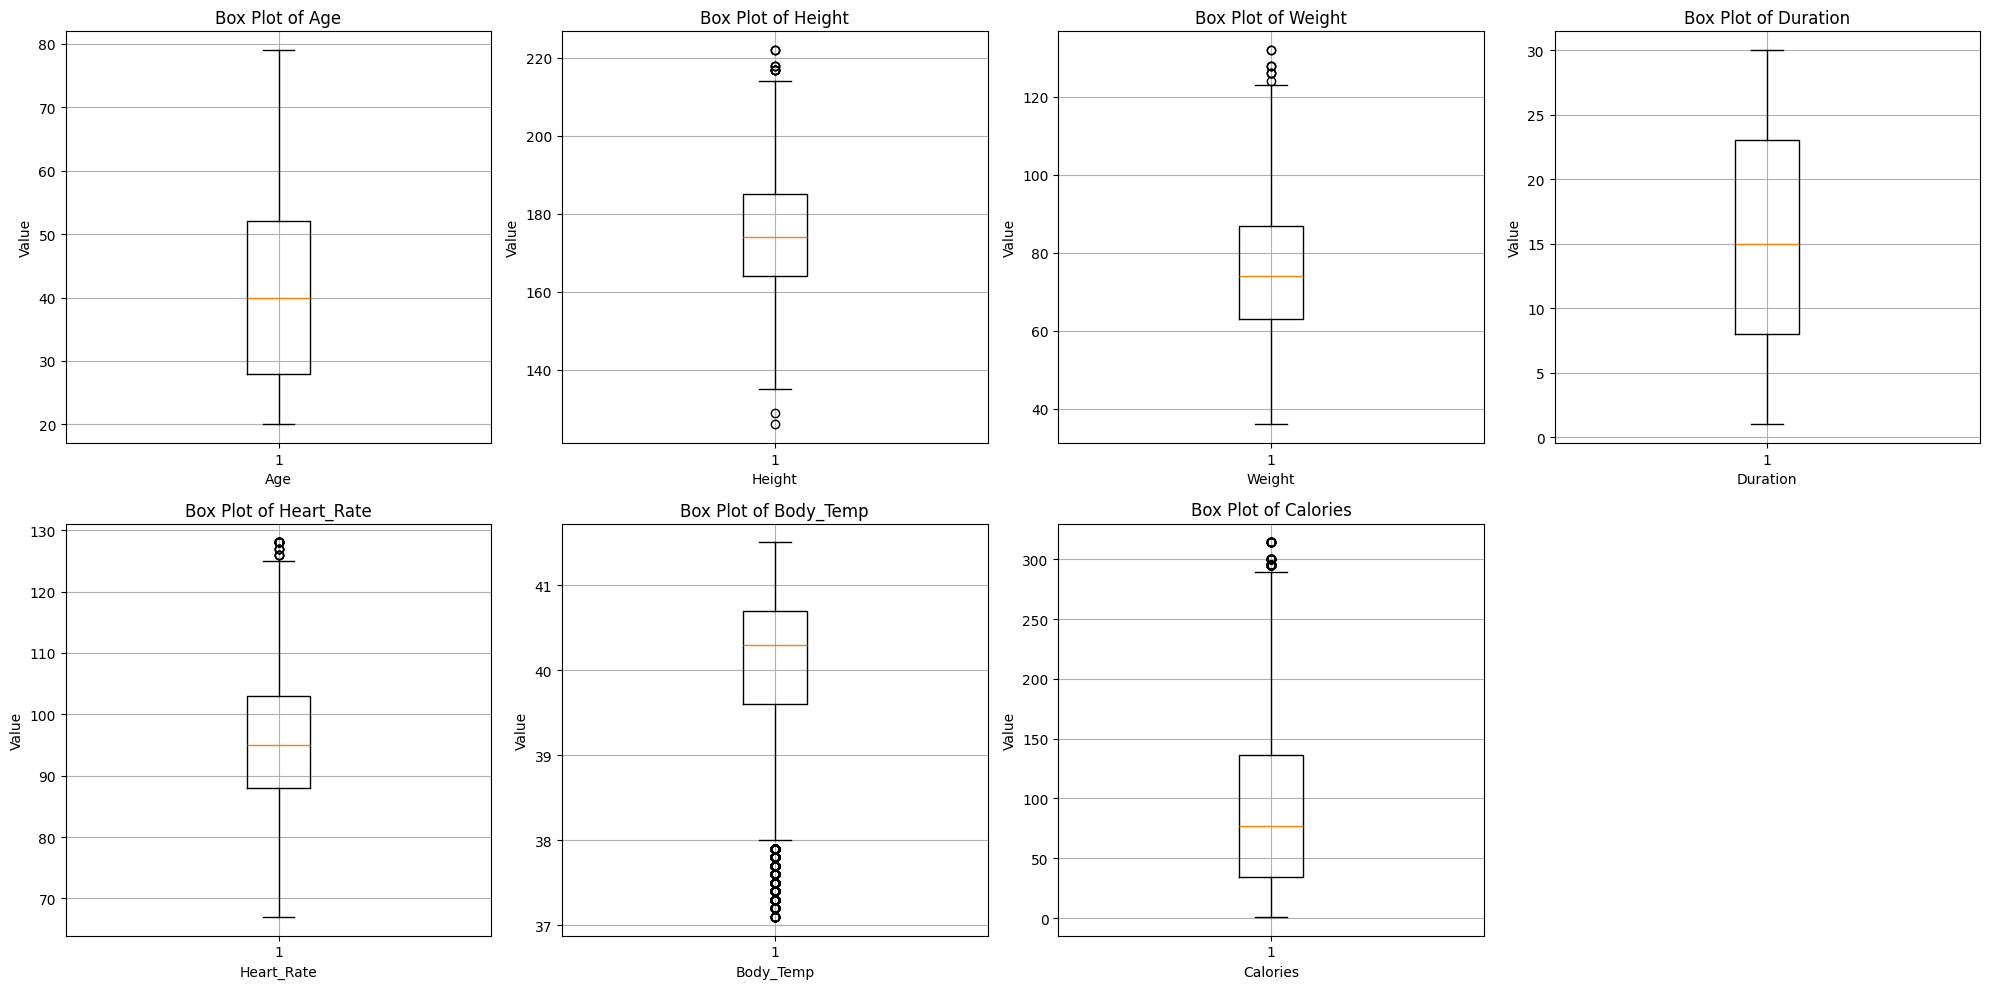

In [81]:
features = ['Age','Height','Weight','Duration','Heart_Rate','Body_Temp','Calories']
fig,axes = plt.subplots(nrows=2, ncols = 4,figsize = (20,10))
axes = axes.flatten()

for i,feature in enumerate(features):
    axes[i].boxplot(df[feature])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Value')
    axes[i].grid(True)

for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Observations:
- Body temperature has a lot of outliers are the left tail
- The spread of Duration variable is the highest amongst other, and we already know it has uniform distribution. Thus, the dataset has a high range of duration values wih uniform distribution

**Investigating IQR for all data and seeing how many observations are outside the range**

In [82]:
def fn_calcIQR_Outlier_Count(df):
    results=[]

    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        z_scores_values = np.round(np.abs(stats.zscore(df[column])),2)
        Z_scores_outliers_count = sum([1 for z in z_scores_values if z > 3])
        lower_bound = np.round(Q1 - 1.5 * IQR,2)
        upper_bound = np.round(Q3 + 1.5 * IQR,2)
        below_lower = df[df[column] < lower_bound].shape[0]
        above_upper = df[df[column] > upper_bound].shape[0]
        
        results.append({
            'Column': column,
            'IQR': IQR,
            
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Below Lower Bound': below_lower,
            'Above Upper Bound': above_upper,
            'z_scores': Z_scores_outliers_count,
                })
    
    return pd.DataFrame(results)

# Calculate IQR, bounds, and outlier counts
outlier_info = fn_calcIQR_Outlier_Count(df[features])
outlier_info

Column    IQR  Lower Bound  Upper Bound  Below Lower Bound  \
0         Age   24.0        -8.00        88.00                  0   
1      Height   21.0       132.50       216.50                  2   
2      Weight   24.0        27.00       123.00                  0   
3    Duration   15.0       -14.50        45.50                  0   
4  Heart_Rate   15.0        65.50       125.50                  0   
5   Body_Temp    1.1        37.95        42.35              14919   
6    Calories  102.0      -119.00       289.00                  0   

   Above Upper Bound  z_scores  
0                  0         0  
1                 12        38  
2                  9       104  
3                  0         0  
4                 36       175  
5                  0      3368  
6                139       312

In [83]:

# Calculate Median and MAD (Median Absolute Deviation)
median_value = np.median(df['Body_Temp'])
mad = median_abs_deviation(df['Body_Temp'])

# Calculate the modified Z-scores
modified_z_scores = 0.6745 * (df['Body_Temp'] - median_value) / mad

# Count the observations with modified Z-score greater than a threshold (e.g., 3.5)
outliers = (np.abs(modified_z_scores) > 3.5).sum()

print(f"Count of outliers based on Modified Z-Score: {outliers}")

Count of outliers based on Modified Z-Score: 27299


Analysing Outliers by Sex using Box plot

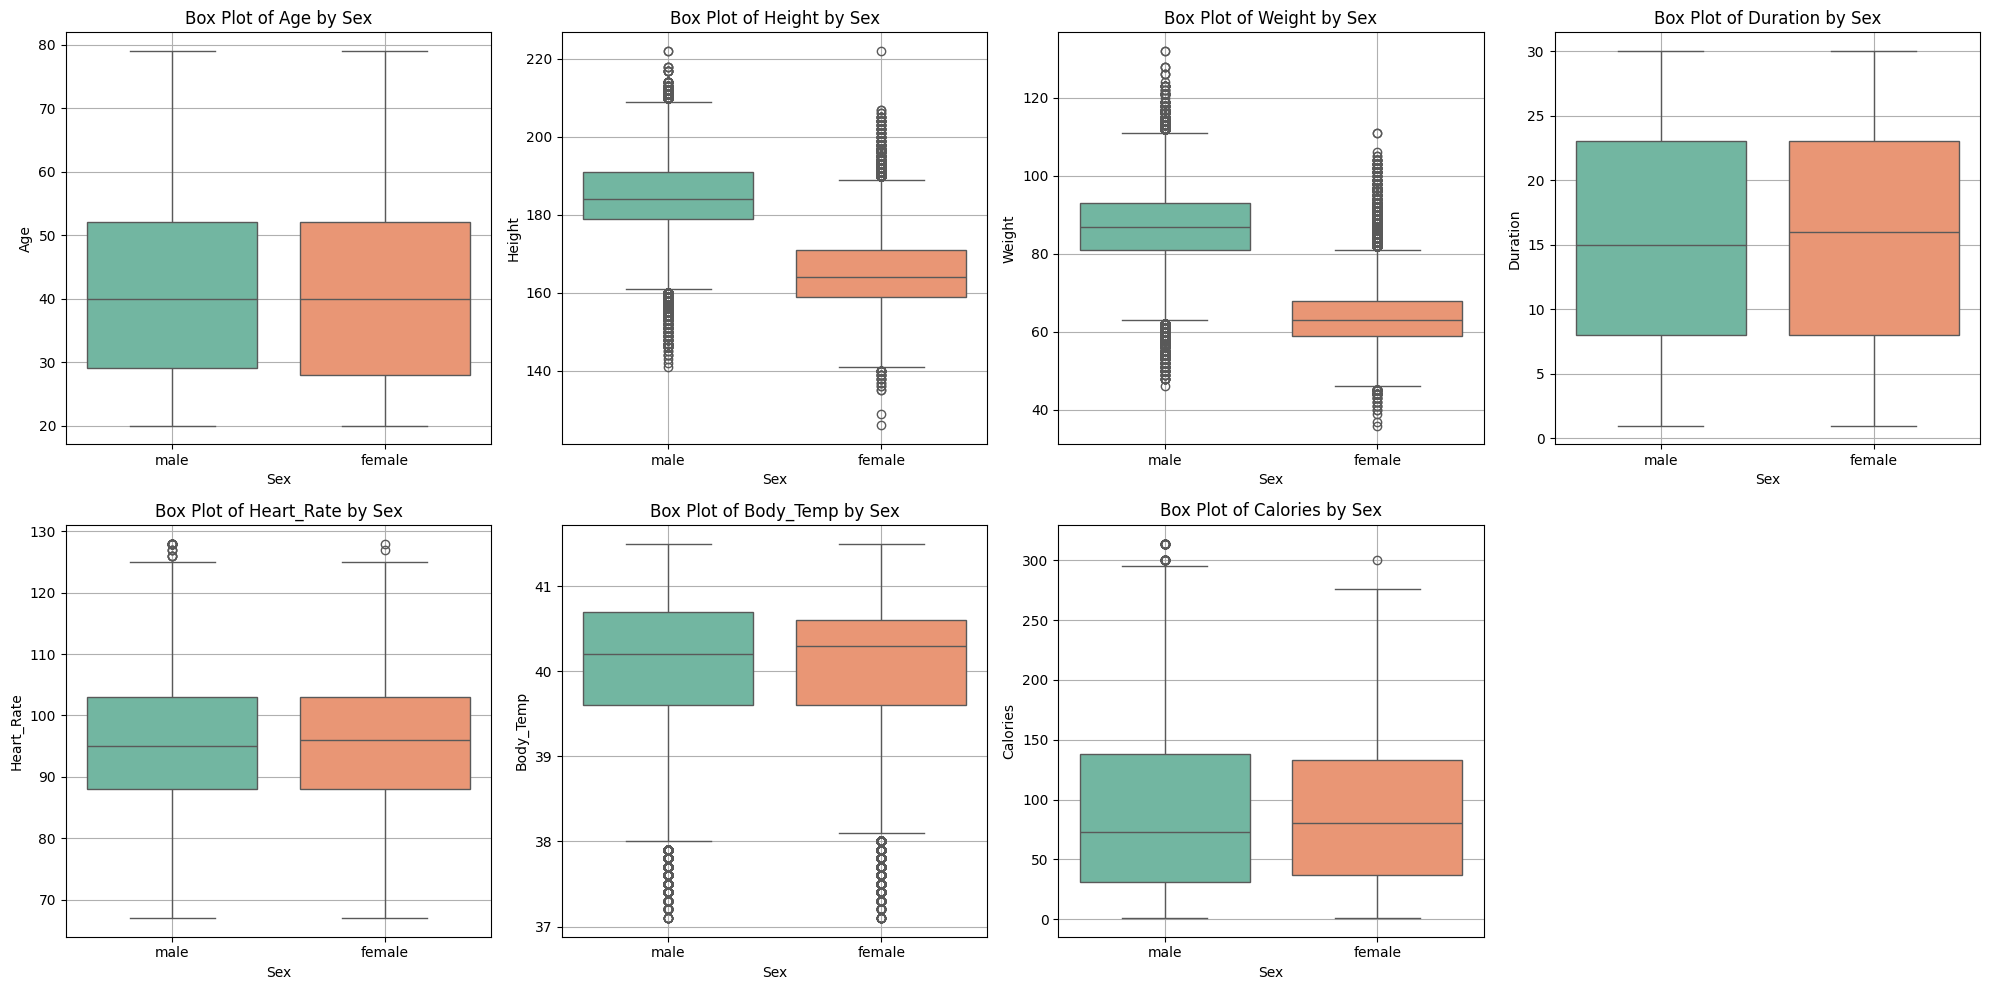

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(data=df, x='Sex', y=feature, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Box Plot of {feature} by Sex')
    axes[i].set_xlabel('Sex')
    axes[i].set_ylabel(feature)
    axes[i].grid(True)

# Turn off unused subplot if any
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Observation: <br>
- From box plots, it's observed that for male & feamale, only the height and weight variables are significantly different, and this is in line with generic expectation where men have higher height and weight than females.

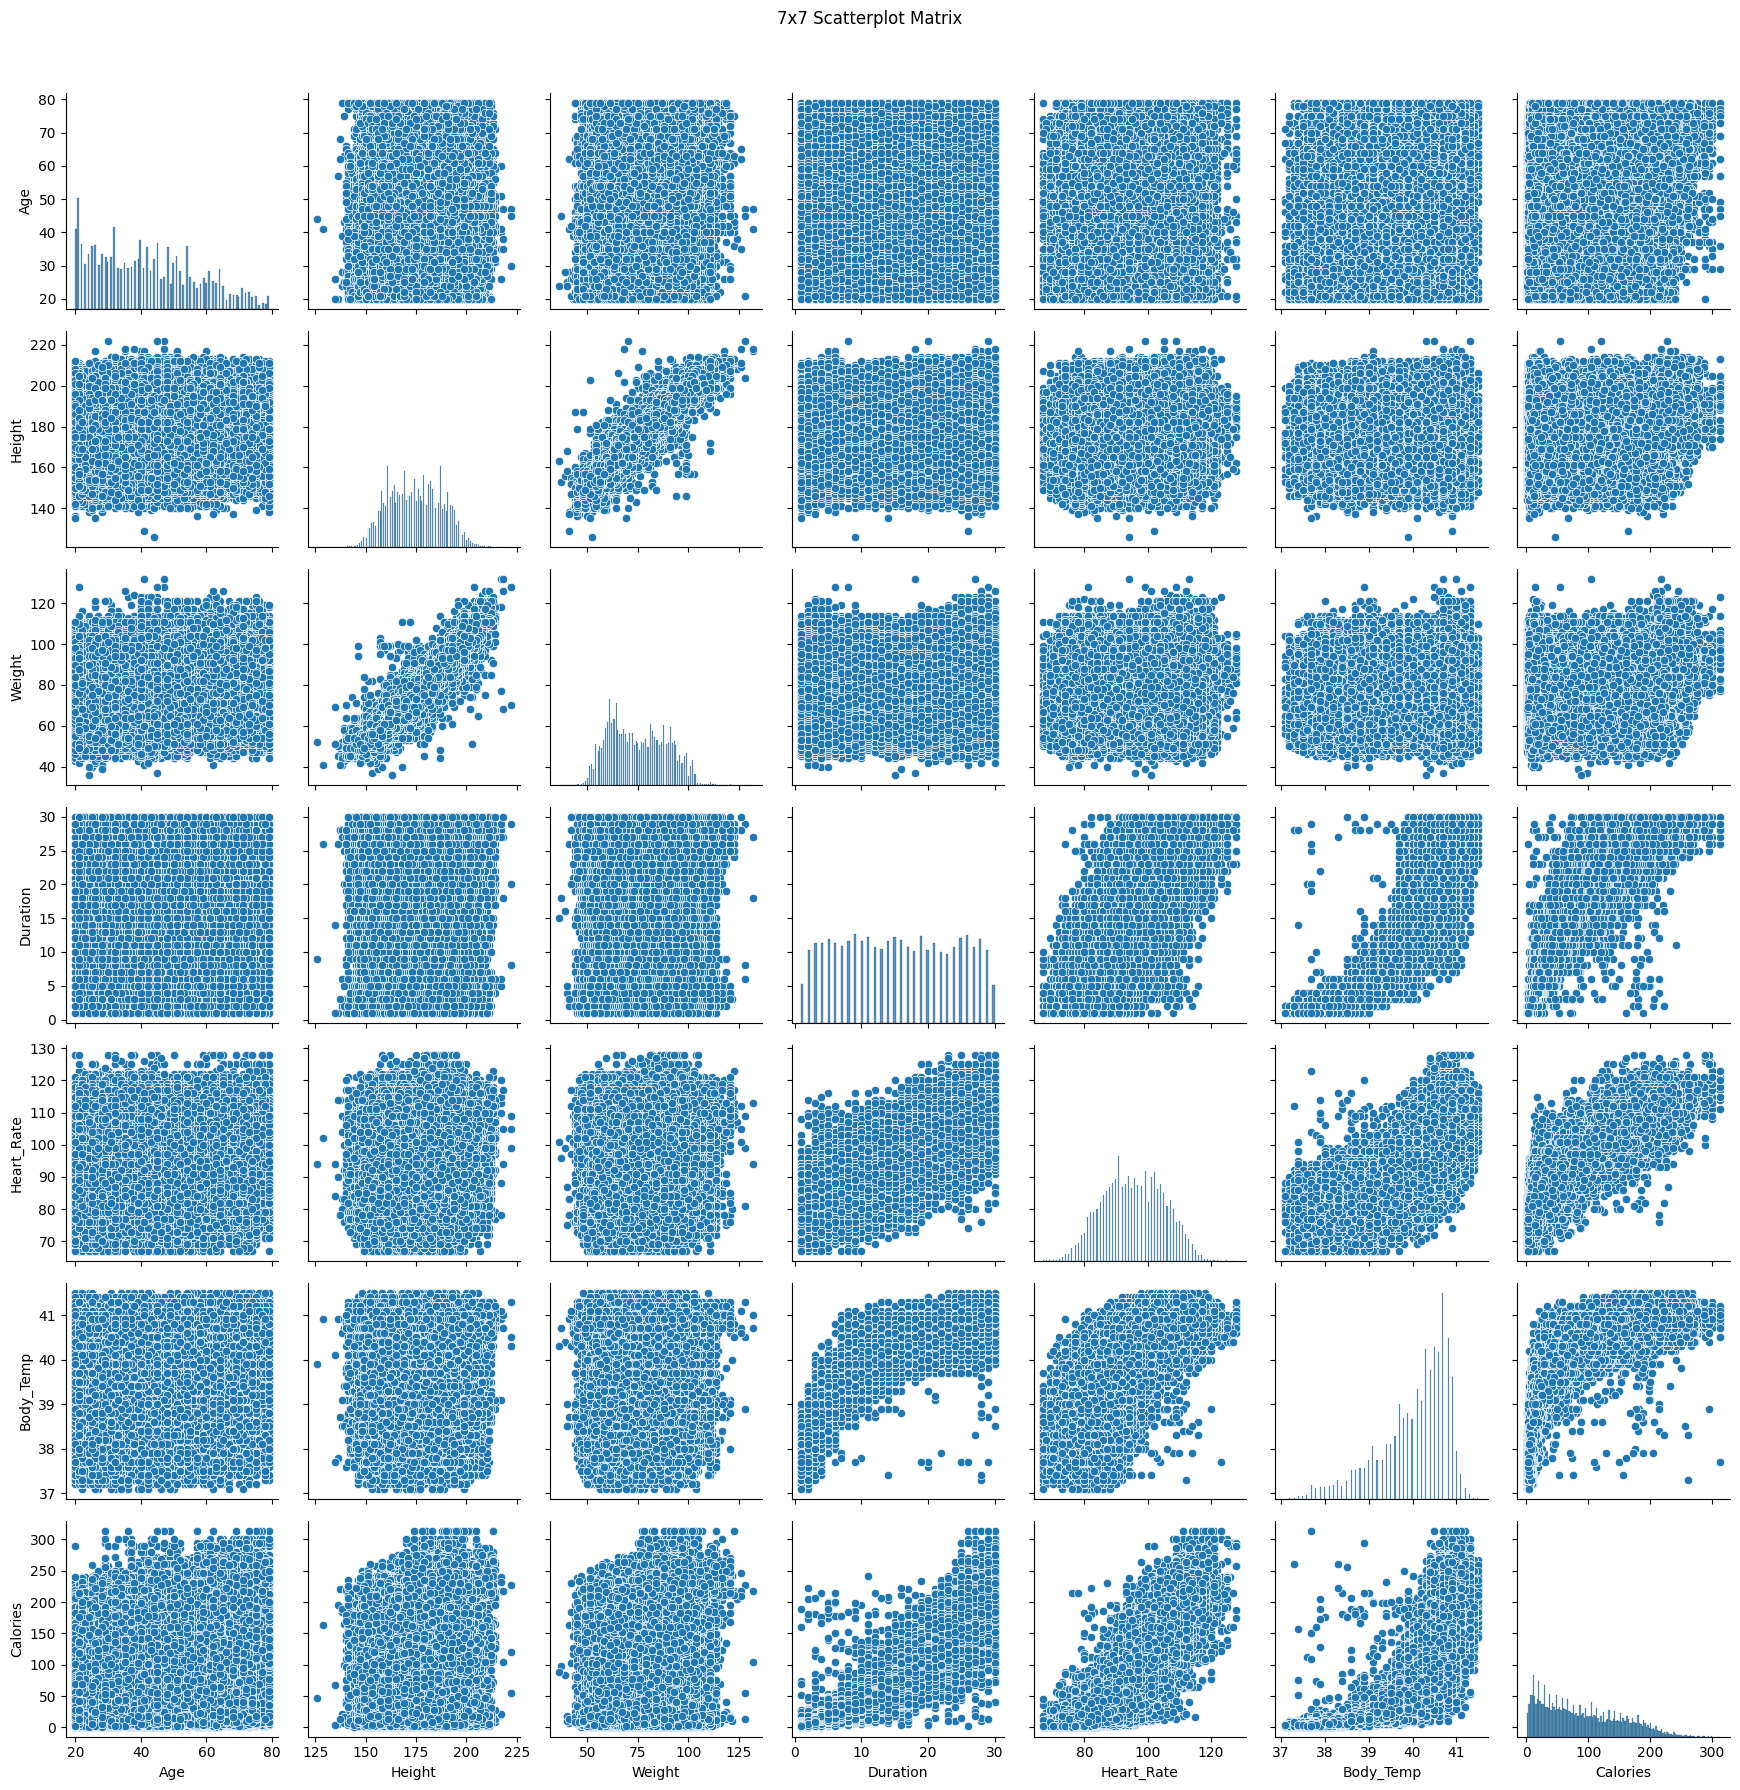

In [85]:
sns.pairplot(df)
plt.suptitle("7x7 Scatterplot Matrix", y=1.02)
plt.tight_layout()
plt.show()

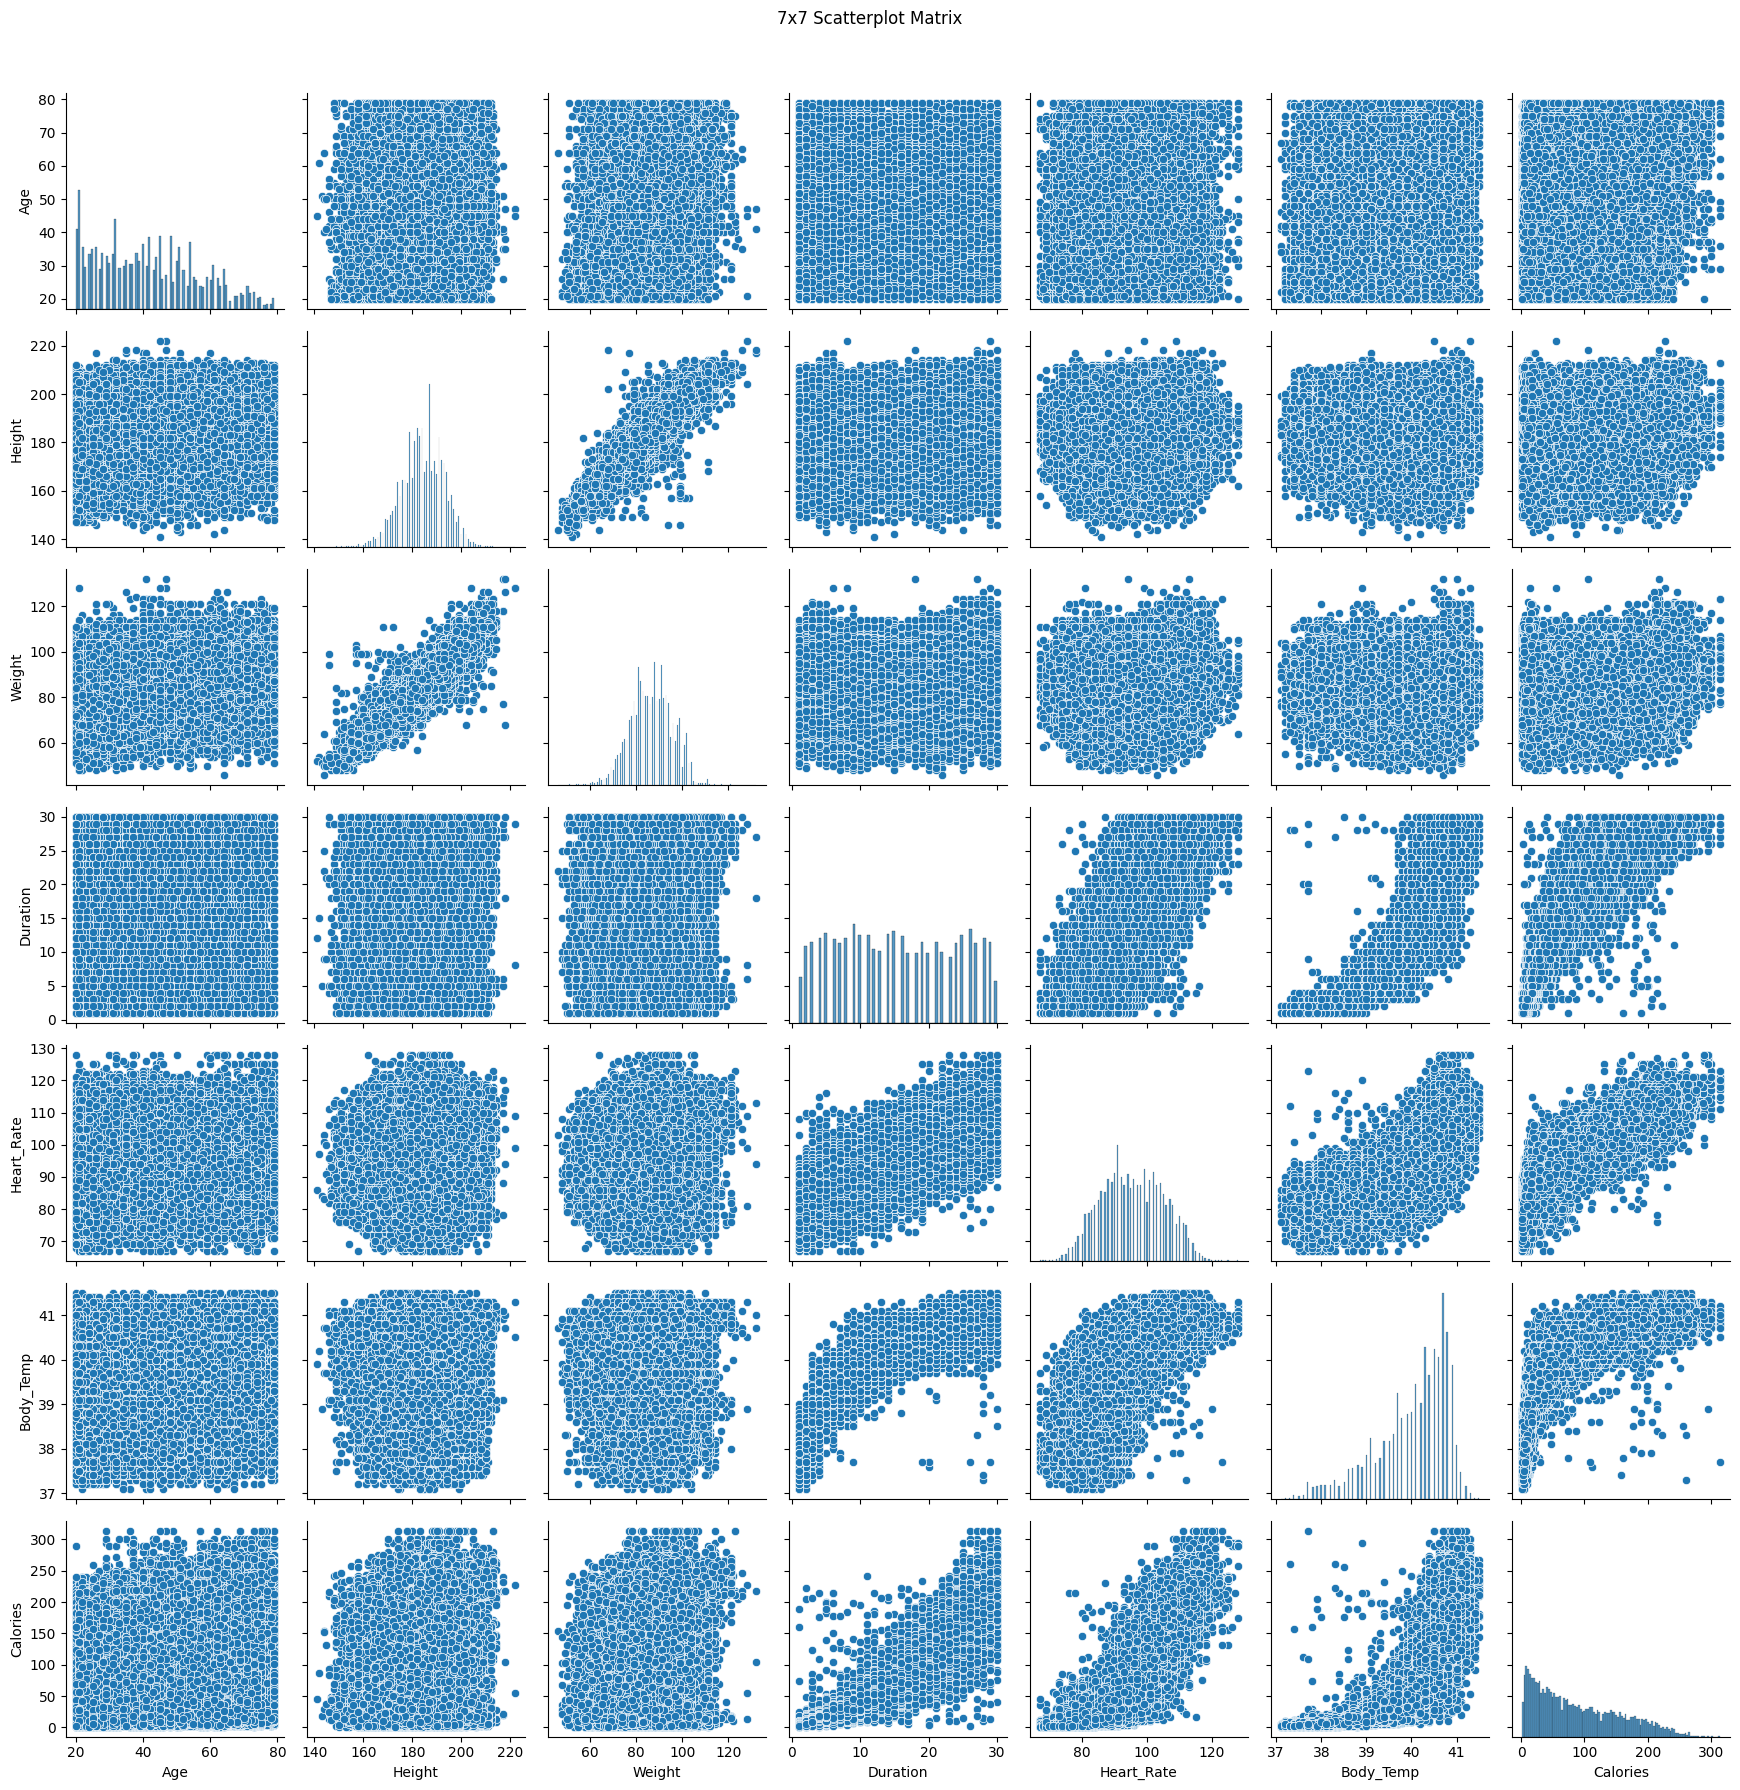

In [86]:
df_male = df[df['Sex']=='male']
sns.pairplot(df_male)
plt.suptitle("7x7 Scatterplot Matrix", y=1.02)
plt.tight_layout()
plt.show()

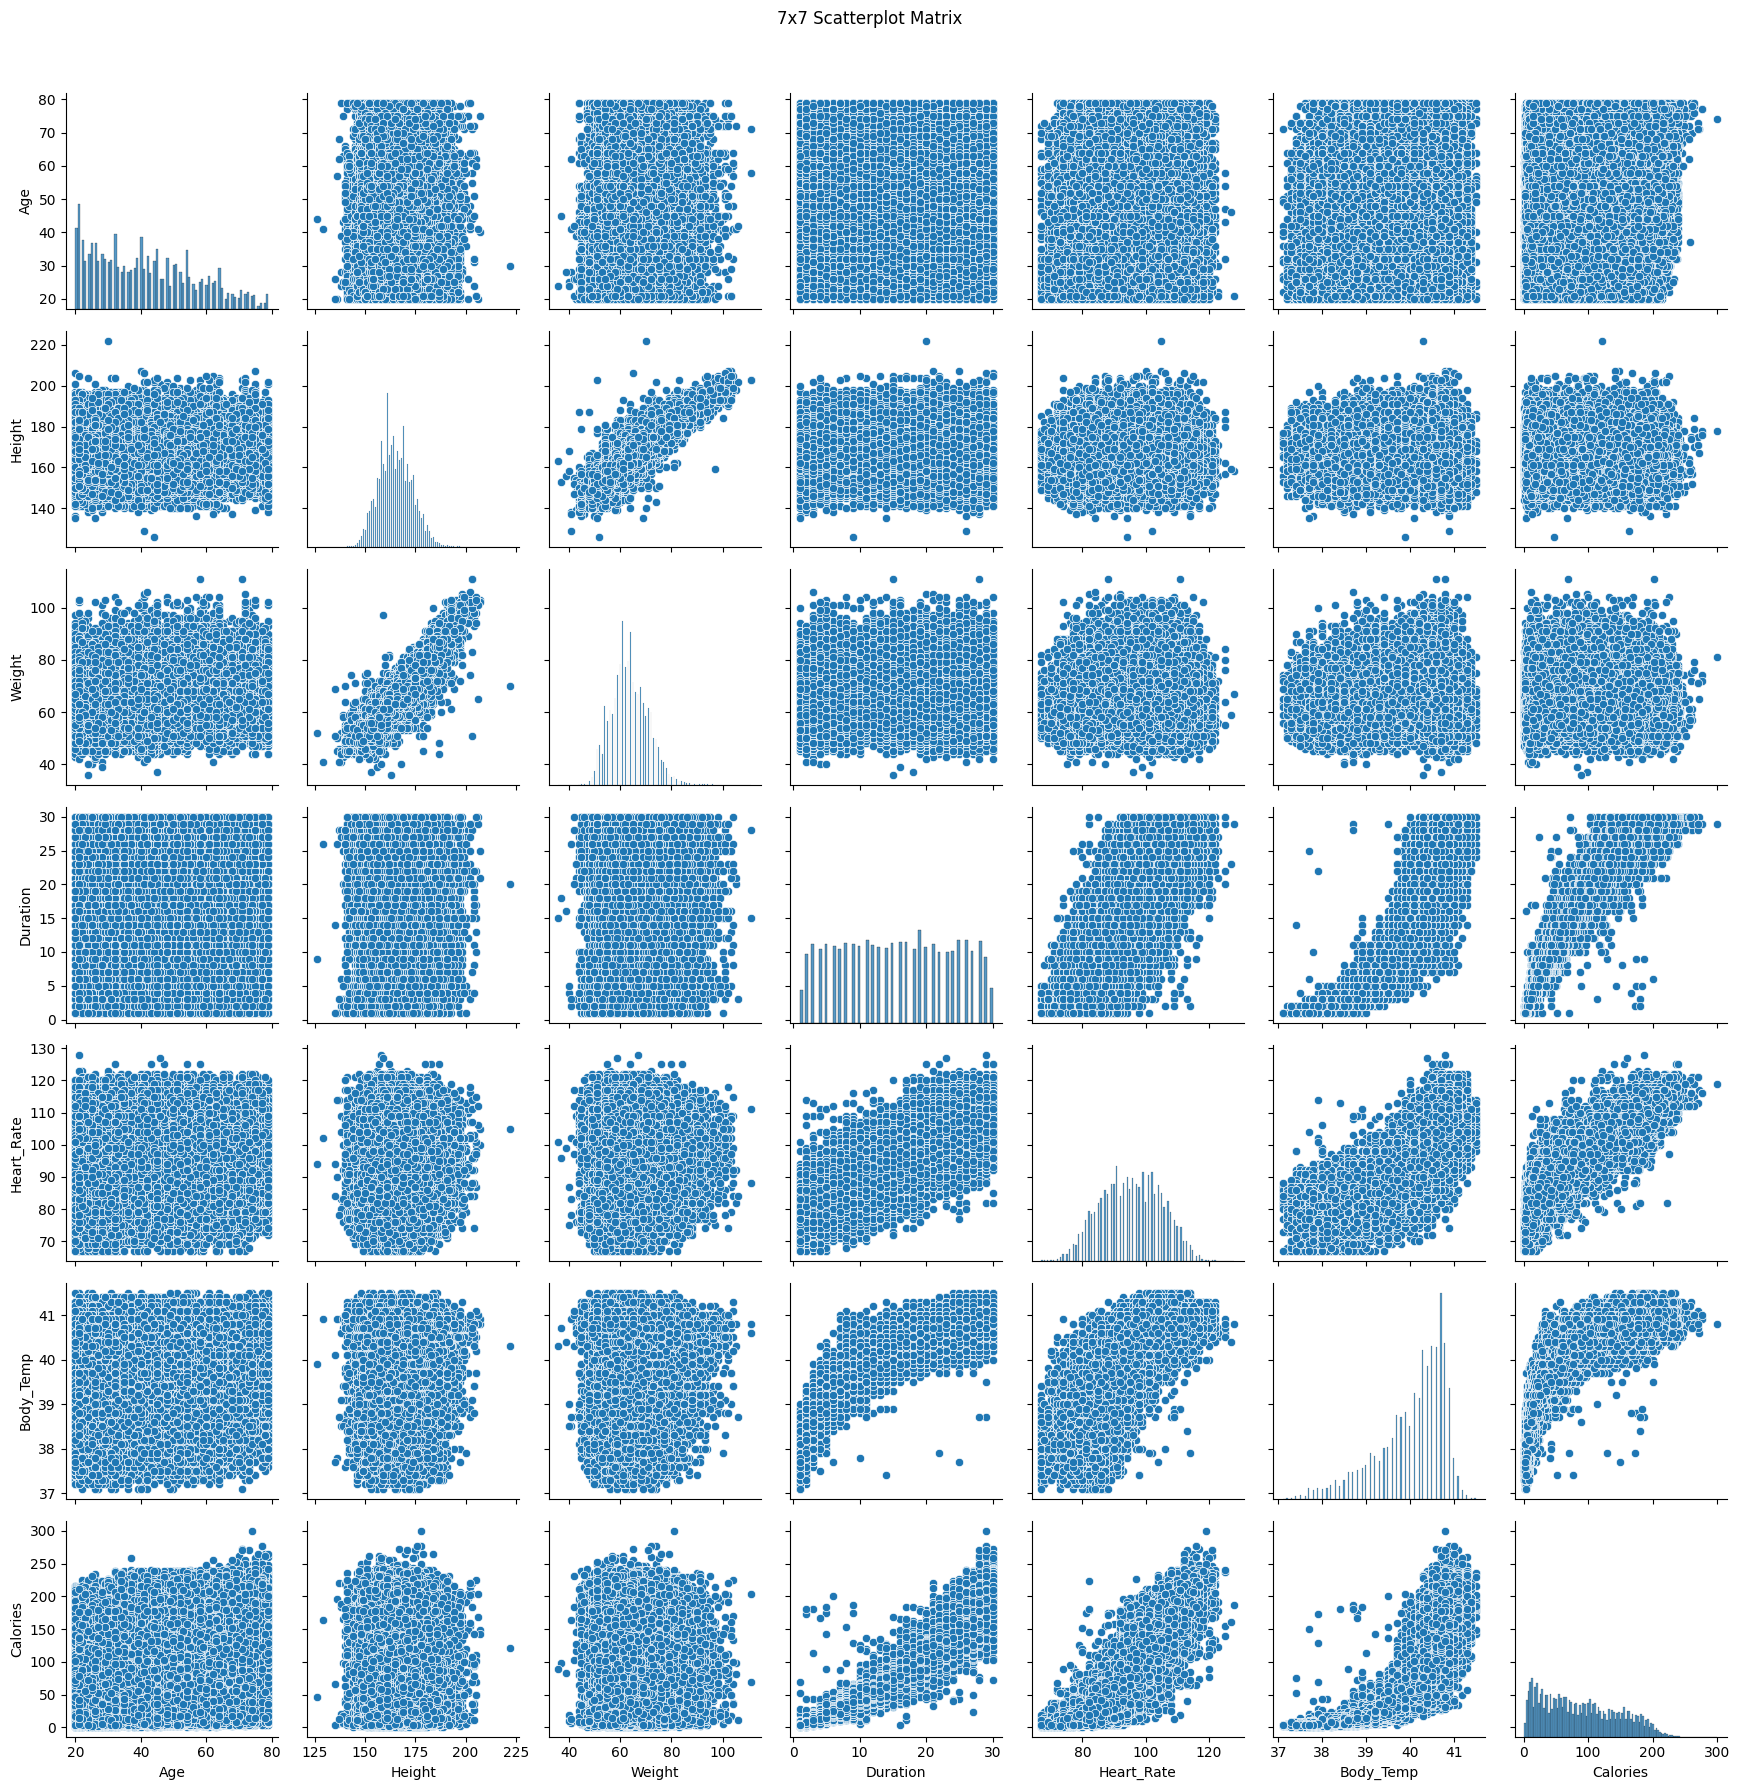

In [87]:
df_female = df[df['Sex']=='female']
sns.pairplot(df_female)
plt.suptitle("7x7 Scatterplot Matrix", y=1.02)
plt.tight_layout()
plt.show()

Correlation plot

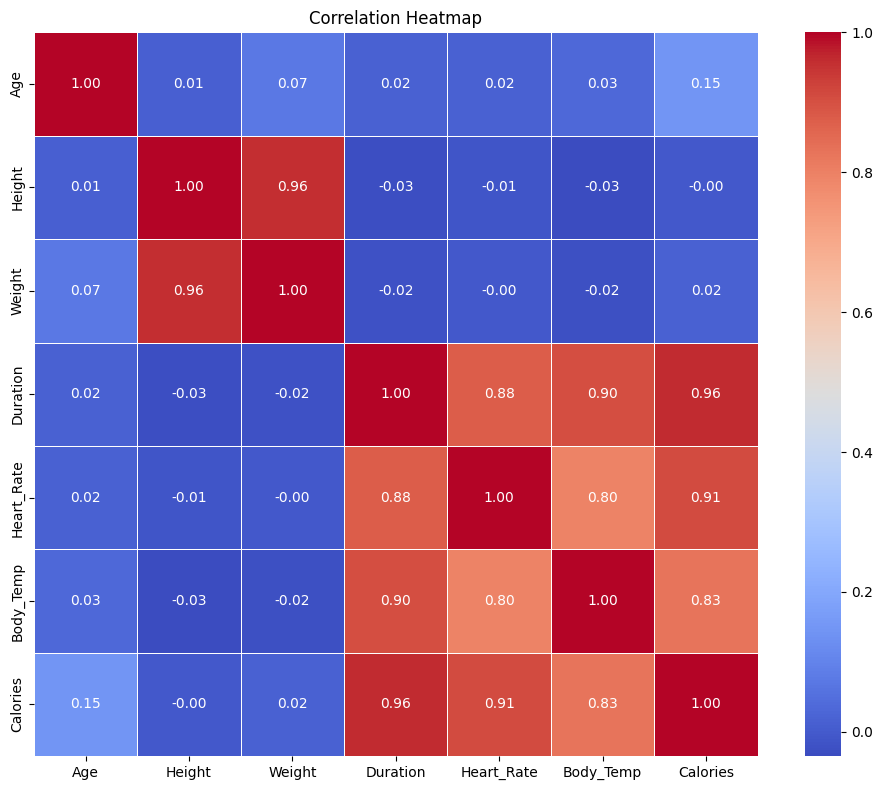

In [88]:
#creating a heatmap

# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Set up the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


**Multicollinearity:**
1. Height and Weight have 0.96 correlation between each other
2. Duration, Heart_Rate, Body_temperature and Calories have high correlation

In [89]:
import pandas as pd
import numpy as np

corr_matrix = df.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if upper.loc[row, col] > 0.8
]

print(high_corr_pairs)


[('Weight', 'Height', 0.9579665118458504), ('Heart_Rate', 'Duration', 0.8753270681992043), ('Body_Temp', 'Duration', 0.903065980941379), ('Calories', 'Duration', 0.9599076133826594), ('Calories', 'Heart_Rate', 0.9087477973376673), ('Calories', 'Body_Temp', 0.8286712223888946)]


# Statistical Analysis

In [90]:
def plot_correlation_heatmap(corr):
    """Plot correlation heatmap using plotly"""
    fig = px.imshow(corr,
                    template="plotly",
                    title="Correlation Heatmap - Shows strength of relationships (-1 to +1)", 
                    color_continuous_scale="RdBu",
                    width=1000,
                    height=800,
                    labels={"x": "Features",
                           "y": "Features", 
                           "color": "Correlation",
                           "text": "Correlation Value"})
    fig.update_traces(text=corr.round(2), texttemplate="%{text}")
    fig.show()

def plot_correlation_bars(corr):
    """Plot bar chart of pairwise correlations"""
    corr_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            corr_pairs.append({
                'Pair': f"{corr.columns[i]} vs {corr.columns[j]}", 
                'Correlation': corr.iloc[i,j]
            })
    corr_df = pd.DataFrame(corr_pairs)
    
    # Sort by absolute correlation value
    corr_df = corr_df.reindex(corr_df.Correlation.abs().sort_values(ascending=False).index)
    
    fig = px.bar(corr_df,
                 x='Pair',
                 y='Correlation', 
                 title="Pairwise Correlations - Sorted by Strength",
                 template="plotly",
                 width=800,
                 height=500,
                 color='Correlation',
                 color_continuous_scale=['red', 'lightgray', 'blue'],
                 text='Correlation')
    fig.update_layout(xaxis_tickangle=45)
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    fig.show()

def perform_normality_test(numeric_df):
    """Perform Shapiro-Wilk normality test"""
    print("\nNormality Testing")
    print("-" * 30)
    print("""
    The Shapiro-Wilk test checks if data follows a normal distribution:
    - Null hypothesis (H0): Data is normally distributed
    - Alternative hypothesis (H1): Data is not normally distributed
    - If p-value > 0.05: Data likely follows normal distribution
    - If p-value ≤ 0.05: Data likely does not follow normal distribution
    """)
    
    results = []
    for col in numeric_df.columns:
        stat, p = stats.shapiro(numeric_df[col])
        results.append({
            'Variable': col,
            'Test Statistic': round(stat, 4),
            'p-value': round(p, 3),
            'Normal Distribution?': 'Yes (p>0.05)' if p > 0.05 else 'No (p≤0.05)'
        })
    
    results_df = pd.DataFrame(results)
    display(results_df)

def perform_cohort_analysis(df, numeric_df):
    """Perform cohort analysis by sex using Mann-Whitney U test"""
    print("\nCohort Analysis by Sex")
    print("-" * 30)
    print("""
    Mann-Whitney U test compares distributions between male and female groups:
    - Null hypothesis (H0): No significant difference between groups
    - Alternative hypothesis (H1): Significant difference exists between groups
    - If p-value > 0.05: No significant difference
    - If p-value ≤ 0.05: Significant difference exists
    """)

    cohort_results = []
    for col in numeric_df.columns:
        male_data = df[df['Sex'] == 'male'][col]
        female_data = df[df['Sex'] == 'female'][col]
        
        # Skip if either group has no data
        if len(male_data) == 0 or len(female_data) == 0:
            continue
            
        # Calculate medians for each group
        male_median = male_data.median()
        female_median = female_data.median()
        
        # Perform Mann-Whitney U test
        stat, p = stats.mannwhitneyu(male_data, female_data, alternative='two-sided')
        
        cohort_results.append({
            'Variable': col,
            'Male Median': round(male_median, 2),
            'Female Median': round(female_median, 2),
            'Difference': round(male_median - female_median, 2),
            'p-value': round(p, 3),
            'Significant Difference?': 'Yes (p≤0.05)' if p <= 0.05 else 'No (p>0.05)'
        })
    
    cohort_df = pd.DataFrame(cohort_results)
    display(cohort_df)


In [91]:

numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
plot_correlation_heatmap(corr)


In [92]:

plot_correlation_bars(corr)


In [93]:
perform_normality_test(numeric_df)



Normality Testing
------------------------------

    The Shapiro-Wilk test checks if data follows a normal distribution:
    - Null hypothesis (H0): Data is normally distributed
    - Alternative hypothesis (H1): Data is not normally distributed
    - If p-value > 0.05: Data likely follows normal distribution
    - If p-value ≤ 0.05: Data likely does not follow normal distribution
    


Variable  Test Statistic  p-value Normal Distribution?
0         Age          0.9538      0.0          No (p≤0.05)
1      Height          0.9843      0.0          No (p≤0.05)
2      Weight          0.9678      0.0          No (p≤0.05)
3    Duration          0.9544      0.0          No (p≤0.05)
4  Heart_Rate          0.9907      0.0          No (p≤0.05)
5   Body_Temp          0.9137      0.0          No (p≤0.05)
6    Calories          0.9432      0.0          No (p≤0.05)

In [94]:
perform_cohort_analysis(df, numeric_df)


Cohort Analysis by Sex
------------------------------

    Mann-Whitney U test compares distributions between male and female groups:
    - Null hypothesis (H0): No significant difference between groups
    - Alternative hypothesis (H1): Significant difference exists between groups
    - If p-value > 0.05: No significant difference
    - If p-value ≤ 0.05: Significant difference exists
    


Variable  Male Median  Female Median  Difference  p-value  \
0         Age         40.0           40.0         0.0      0.0   
1      Height        184.0          164.0        20.0      0.0   
2      Weight         87.0           63.0        24.0      0.0   
3    Duration         15.0           16.0        -1.0      0.0   
4  Heart_Rate         95.0           96.0        -1.0      0.0   
5   Body_Temp         40.2           40.3        -0.1      0.0   
6    Calories         73.0           80.0        -7.0      0.0   

  Significant Difference?  
0            Yes (p≤0.05)  
1            Yes (p≤0.05)  
2            Yes (p≤0.05)  
3            Yes (p≤0.05)  
4            Yes (p≤0.05)  
5            Yes (p≤0.05)  
6            Yes (p≤0.05)

# Preprocesing Data for Model Building

In [95]:

def preprocess_data(df, sample_size=10000, page="Data Preprocessing"):
    # Reduce dataset to 1000 records
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    # Split features and target
    X = df.drop('Calories', axis=1)
    y = df['Calories']
    
    # Create preprocessing pipeline
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Feature Selection
    X_processed = preprocessor.fit_transform(X)
    
    selector = SelectKBest(score_func=f_regression, k=5)
    X_selected = selector.fit_transform(X_processed, y)
    
    # Display preprocessing info
    print("Splitting data into features (X) and target variable (Calories)")
    print("\nFeatures (X):")
    display(X.head())
    print("\nTarget (y):")
    display(y.head())
    
    print("\nCreating preprocessing pipeline for numeric and categorical features")
    print(f"Numeric features: {numeric_features.tolist()}")
    print(f"Categorical features: {categorical_features.tolist()}")
    
    print("\nNumeric features will be standardized using StandardScaler")
    print("Categorical features will be one-hot encoded, dropping first category")
    
    print("\nFeature Selection")
    print("\nApplying preprocessing transformations to features")
    processed_df = pd.DataFrame(X_processed)
    print("Processed features after scaling and encoding:")
    display(processed_df.head())
    
    print("\nSelecting top 5 most important features using f_regression")
    selected_df = pd.DataFrame(X_selected)
    print("Final selected features:")
    display(selected_df.head())
    
    selected_features = selector.get_support()
    print(f"\nSelected Features: {X.columns[selected_features].tolist()}")
    
    return X_selected, y, preprocessor, selector



In [96]:
X_selected, y, preprocessor, selector = preprocess_data(df, sample_size=10000000, page="Data Preprocessing")

Splitting data into features (X) and target variable (Calories)

Features (X):


Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0    male   36   189.0    82.0      26.0       101.0       41.0
1  female   64   163.0    60.0       8.0        85.0       39.7
2  female   51   161.0    64.0       7.0        84.0       39.8
3    male   20   192.0    90.0      25.0       105.0       40.7
4  female   38   166.0    61.0      25.0       102.0       40.6


Target (y):


0    150.0
1     34.0
2     29.0
3    140.0
4    146.0
Name: Calories, dtype: float64


Creating preprocessing pipeline for numeric and categorical features
Numeric features: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
Categorical features: ['Sex']

Numeric features will be standardized using StandardScaler
Categorical features will be one-hot encoded, dropping first category

Feature Selection

Applying preprocessing transformations to features
Processed features after scaling and encoding:


0         1         2         3         4         5    6
0 -0.357192  1.115235  0.490201  1.266324  0.583714  1.235772  1.0
1  1.487943 -0.912137 -1.083172 -0.888309 -1.109436 -0.431163  0.0
2  0.631273 -1.068088 -0.797104 -1.008011 -1.215258 -0.302938  0.0
3 -1.411555  1.349162  1.062337  1.146622  1.007002  0.851095  1.0
4 -0.225397 -0.678209 -1.011655  1.146622  0.689536  0.722869  0.0


Selecting top 5 most important features using f_regression
Final selected features:


0         1         2         3         4
0 -0.357192  0.490201  1.266324  0.583714  1.235772
1  1.487943 -1.083172 -0.888309 -1.109436 -0.431163
2  0.631273 -0.797104 -1.008011 -1.215258 -0.302938
3 -1.411555  1.062337  1.146622  1.007002  0.851095
4 -0.225397 -1.011655  1.146622  0.689536  0.722869


Selected Features: ['Sex', 'Height', 'Weight', 'Duration', 'Heart_Rate']


In [97]:
print("\nPreprocessor Pipeline:")
print("----------------------")
print("\nNumerical Features Pipeline:")
print("- Features:", preprocessor.named_transformers_['num'].get_feature_names_out().tolist())
print("- Steps:", [step[0] for step in preprocessor.named_transformers_['num'].steps])

print("\nCategorical Features Pipeline:") 
print("- Features:", preprocessor.named_transformers_['cat'].get_feature_names_out().tolist())
print("- Steps:", [step[0] for step in preprocessor.named_transformers_['cat'].steps])

print("\nFull Preprocessor:")
display(preprocessor)


Preprocessor Pipeline:
----------------------

Numerical Features Pipeline:
- Features: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
- Steps: ['scaler']

Categorical Features Pipeline:
- Features: ['Sex_male']
- Steps: ['onehot']

Full Preprocessor:


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 Index(['Sex'], dtype='object'))])

# Model Configuration

In [98]:
def build_models(X_selected, y):
    print("Model Building")
    print("---")

    # Common parameters
    test_size = 0.2
    n_batches = 10
    selected_batch = 1
    
    print(f"Test Set Size: {test_size}")
    print(f"Number of Batches: {n_batches}")
    print(f"Selected Batch: {selected_batch}")

    # Initialize model configs
    model_configs = {}

    print("\nModel Parameters:")
    
    # Linear Regression Parameters
    print("\nLinear Regression Parameters:")
    lr_fit_intercept = True
    lr_config = {'fit_intercept': lr_fit_intercept}
    print(f"Fit Intercept: {lr_fit_intercept}")
        
    # Decision Tree Parameters
    print("\nDecision Tree Parameters:")
    dt_max_depth = 5
    dt_min_samples_split = 2
    dt_config = {
        'max_depth': dt_max_depth,
        'min_samples_split': dt_min_samples_split
    }
    print(f"Max Depth: {dt_max_depth}")
    print(f"Min Samples Split: {dt_min_samples_split}")
    
    # Random Forest Parameters
    print("\nRandom Forest Parameters:")
    rf_n_estimators = 100
    rf_max_depth = 5
    rf_config = {
        'n_estimators': rf_n_estimators,
        'max_depth': rf_max_depth
    }
    print(f"Number of Trees: {rf_n_estimators}")
    print(f"Max Depth: {rf_max_depth}")
        
    # Gradient Boosting Parameters
    print("\nGradient Boosting Parameters:")
    gb_n_estimators = 100
    gb_learning_rate = 0.1
    gb_config = {
        'n_estimators': gb_n_estimators,
        'learning_rate': gb_learning_rate
    }
    print(f"Number of Trees: {gb_n_estimators}")
    print(f"Learning Rate: {gb_learning_rate}")
    
    # XGBoost Parameters
    print("\nXGBoost Parameters:")
    xgb_n_estimators = 100
    xgb_learning_rate = 0.1
    xgb_max_depth = 5
    xgb_config = {
        'n_estimators': xgb_n_estimators,
        'learning_rate': xgb_learning_rate,
        'max_depth': xgb_max_depth
    }
    print(f"Number of Trees: {xgb_n_estimators}")
    print(f"Learning Rate: {xgb_learning_rate}")
    print(f"Max Depth: {xgb_max_depth}")

    model_configs['Linear Regression'] = lr_config
    model_configs['Decision Tree'] = dt_config
    model_configs['Random Forest'] = rf_config
    model_configs['Gradient Boosting'] = gb_config
    model_configs['XGBoost'] = xgb_config
    
    return X_selected, y, test_size, n_batches, selected_batch, model_configs


In [99]:
X_selected, y, test_size, n_batches, selected_batch, model_configs  = build_models(X_selected, y)

Model Building
---
Test Set Size: 0.2
Number of Batches: 10
Selected Batch: 1

Model Parameters:

Linear Regression Parameters:
Fit Intercept: True

Decision Tree Parameters:
Max Depth: 5
Min Samples Split: 2

Random Forest Parameters:
Number of Trees: 100
Max Depth: 5

Gradient Boosting Parameters:
Number of Trees: 100
Learning Rate: 0.1

XGBoost Parameters:
Number of Trees: 100
Learning Rate: 0.1
Max Depth: 5


# Model Building

In [100]:

def rmsle(y_true, y_pred):
    # Add small constant to avoid log(0)
    y_true = np.clip(y_true, 1e-15, None)
    y_pred = np.clip(y_pred, 1e-15, None)
    return np.sqrt(mean_squared_error(np.log(y_true), np.log(y_pred)))


In [101]:
def train_and_evaluate_models(X_selected, y, test_size, n_batches, selected_batch, model_configs):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=test_size, random_state=42)
    
    models = {
        'Linear Regression': LinearRegression,
        'Decision Tree': DecisionTreeRegressor,
        'Random Forest': RandomForestRegressor,
        'Gradient Boosting': GradientBoostingRegressor,
        'XGBoost': XGBRegressor
    }
    results = {}
    best_score = float('inf')
    best_model = None
    best_model_name = None
    batch_models = {}
    model_results = {}
    
    # Train models that have been submitted
    print("Training models...")
    for i, (name, model_class) in enumerate(models.items()):
        progress = (i + 1) / len(models)
        print(f"Training {name}... {progress*100:.0f}% complete")
        
        if name in model_configs:
            config = model_configs[name]
            
            # Split training data into batches
            n_samples = X_train.shape[0]
            batch_size = n_samples // n_batches
            if n_samples % n_batches != 0:
                batch_size += 1
            
            best_batch_model = None
            best_batch_rmsle = float('inf')
            best_batch_r2 = -float('inf')
            
            print(f"\nTraining {name} on batch {selected_batch}")
            
            start_idx = (selected_batch - 1) * batch_size
            end_idx = min((selected_batch) * batch_size, n_samples)
            
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            
            batch_model = model_class(**config)
            batch_model.fit(X_batch, y_batch)
            
            y_pred = batch_model.predict(X_test)
            batch_rmsle = rmsle(y_test, y_pred)
            batch_r2 = r2_score(y_test, y_pred)
            
            if batch_rmsle < best_batch_rmsle and batch_r2 > best_batch_r2:
                best_batch_model = batch_model
                best_batch_rmsle = batch_rmsle
                best_batch_r2 = batch_r2
            
            y_pred = best_batch_model.predict(X_test)
            rmsle_score = rmsle(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            results[name] = {'RMSLE': rmsle_score, 'R2': r2}
            
            # Store results
            model_key = f"{name}_{hash(str(config))}"
            model_results[model_key] = {
                'config': config,
                'rmsle': rmsle_score,
                'r2': r2
            }
            
            if rmsle_score < best_score:
                best_score = rmsle_score
                best_model = best_batch_model
                best_model_name = name

        batch_models[name] = batch_model

    print("\nModel Performance Comparison:")
    for name, metrics in results.items():
        print(f"\n{name}:")
        print(f"RMSLE: {metrics['RMSLE']:.4f}")
        print(f"R2: {metrics['R2']:.4f}")
        
    if best_model_name:
        print("\nBest Performing Model:")
        print(f"Model: {best_model_name}")
        print(f"RMSLE Score: {best_score:.4f}")
        print(f"R² Score: {results[best_model_name]['R2']:.4f}")
        print("Configuration:")
        print(model_configs[best_model_name])


    print("\nBest Performing Model:")
    print(f"Model: {best_model_name}")
    print(f"RMSLE Score: {best_score:.4f}")
    print(f"R² Score: {results[best_model_name]['R2']:.4f}")
    print("Configuration:")
    print(model_configs[best_model_name])
    
    # Save best model info
    model_configs['Best Model'] = model_configs[best_model_name]
    best_model_info = {
        'model': best_model,
        'name': best_model_name
    }
    # Display results comparison

    return batch_models, model_configs, results



# Model Evaluation

In [102]:
models, model_configs, results = train_and_evaluate_models(X_selected, y, test_size, n_batches, selected_batch, model_configs)


Training models...
Training Linear Regression... 20% complete

Training Linear Regression on batch 1
Training Decision Tree... 40% complete

Training Decision Tree on batch 1
Training Random Forest... 60% complete

Training Random Forest on batch 1
Training Gradient Boosting... 80% complete

Training Gradient Boosting on batch 1
Training XGBoost... 100% complete

Training XGBoost on batch 1

Model Performance Comparison:

Linear Regression:
RMSLE: 7.7765
R2: 0.9683

Decision Tree:
RMSLE: 0.2221
R2: 0.9650

Random Forest:
RMSLE: 0.1999
R2: 0.9725

Gradient Boosting:
RMSLE: 1.3461
R2: 0.9934

XGBoost:
RMSLE: 0.4069
R2: 0.9948

Best Performing Model:
Model: Random Forest
RMSLE Score: 0.1999
R² Score: 0.9725
Configuration:
{'n_estimators': 100, 'max_depth': 5}

Best Performing Model:
Model: Random Forest
RMSLE Score: 0.1999
R² Score: 0.9725
Configuration:
{'n_estimators': 100, 'max_depth': 5}


In [103]:
def plot_model_comparison(results):
    """
    Plot comparison of model performance metrics using plotly.
    
    Args:
        results (dict): Dictionary containing model results with RMSLE and R2 scores
    """
    if results:
        fig = go.Figure(data=[
            go.Bar(name='RMSLE', 
                  x=list(results.keys()), 
                  y=[r['RMSLE'] for r in results.values()],
                  text=[f'{r["RMSLE"]:.3f}' for r in results.values()],
                  textposition='outside'),
            go.Bar(name='R2', 
                  x=list(results.keys()), 
                  y=[r['R2'] for r in results.values()],
                  text=[f'{r["R2"]:.3f}' for r in results.values()],
                  textposition='outside')
        ])

        fig.update_layout(
            title='Model Performance Metrics',
            xaxis_title='Model',
            yaxis_title='Score',
            barmode='group',
            template='plotly_white',
            width=1000,
            height=600,
            showlegend=True
        )

        fig.show()

In [104]:
plot_model_comparison(results)


# Unseen Data Prediction

In [105]:
def make_predictions(file_path, preprocessor, selector, models, model_configs, best_model):
    print("=" * 50)
    print("Prediction on New Data")
    print("=" * 50)
    print()
    
    if file_path:
        pred_df = pd.read_csv(file_path)
        
        X_new = preprocessor.transform(pred_df)
        X_new_selected = selector.transform(X_new)
        
        print("\nAvailable Models:")
        print("0. Best Model")
        for i, model_name in enumerate(models.keys(), 1):
            print(f"{i}. {model_name}")
            
        selected_model = models[best_model]
            
        print(f"\nSelected Model: {best_model}")
        print(f"Selected Model Configuration: {model_configs[best_model]}")

        predictions = selected_model.predict(X_new_selected)
        
        pred_df['Predicted_Calories'] = predictions
        pred_df = pred_df[['id', 'Predicted_Calories']].rename(columns={'Predicted_Calories': 'Calories'})
        
        print("\nPredictions:")
        display(pred_df)
        
        print("\nSummary Statistics:")
        print(f"Number of Predictions: {len(pred_df)}")
        print(f"Average Predicted Calories: {pred_df['Calories'].mean():.2f}")
        print(f"Min Predicted Calories: {pred_df['Calories'].min():.2f}")
        print(f"Max Predicted Calories: {pred_df['Calories'].max():.2f}")
        
        # Save predictions to CSV
        output_file = "predictions.csv"
        pred_df.to_csv(output_file, index=False)
        print(f"\nPredictions saved to: {output_file}")


In [106]:
file_path = 'test.csv'
best_model = 'Random Forest'
make_predictions(file_path, preprocessor, selector, models, model_configs, best_model)

Prediction on New Data


Available Models:
0. Best Model
1. Linear Regression
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. XGBoost

Selected Model: Random Forest
Selected Model Configuration: {'n_estimators': 100, 'max_depth': 5}

Predictions:


id    Calories
0       750000   29.518934
1       750001  107.510127
2       750002   87.811970
3       750003  118.579508
4       750004   71.065353
...        ...         ...
249995  999995   21.577379
249996  999996    9.440863
249997  999997   73.126598
249998  999998  174.514434
249999  999999   87.811970

[250000 rows x 2 columns]


Summary Statistics:
Number of Predictions: 250000
Average Predicted Calories: 88.20
Min Predicted Calories: 7.20
Max Predicted Calories: 235.65

Predictions saved to: predictions.csv
